# Dataset 1 (Heart attack prediction)

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dropout
from keras import regularizers

import warnings
warnings.filterwarnings('ignore') 

## Loadind data

In [8]:
df = pd.read_csv('heart.csv')

In [9]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


**Attribute Information:**
* `Age`: age of the patient [years]

* `Sex`: sex of the patient [M: Male, F: Female]

* `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

* `RestingBP`: resting blood pressure [mm Hg]

* `Cholesterol`: serum cholesterol [mm/dl]

* `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

* `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

* `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]

* `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]

* `Oldpeak`: oldpeak = ST [Numeric value measured in depression]

* `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

* `HeartDisease`: output class [1: heart disease, 0: Normal]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


* We have total **12** attributes and **918** observations.

* We have **7** numerical and **5** categorical columns.

## EDA

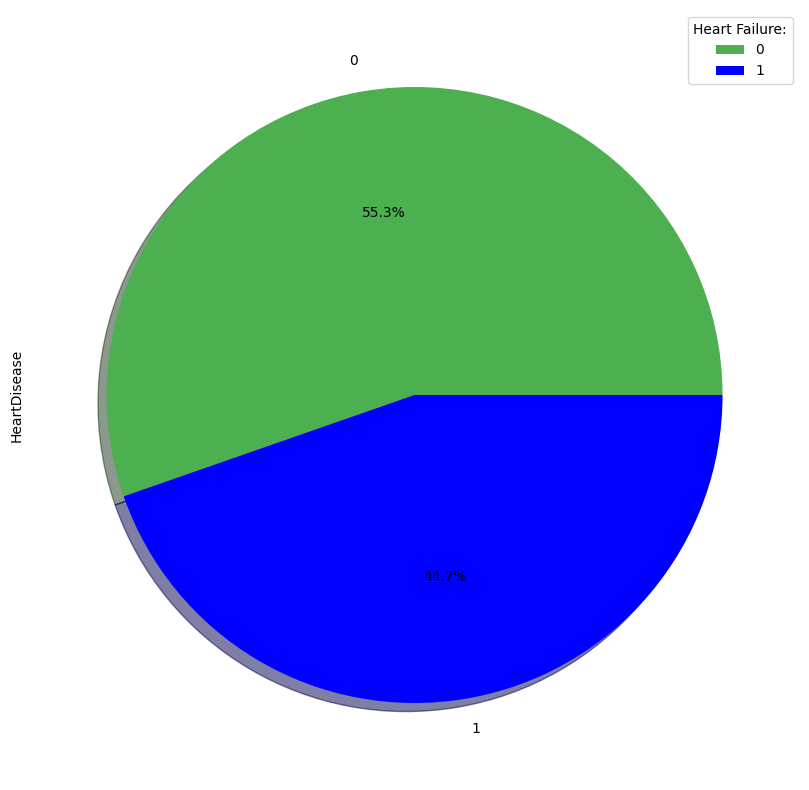

In [11]:
plt.figure(1, figsize=(10,10))
df['HeartDisease'].value_counts().plot.pie(autopct="%1.1f%%",colors = ( "#4CAF50", "blue"),labels = df['HeartDisease'].unique(), shadow = True)
plt.legend(title = "Heart Failure:")
plt.show()

*  55.3 percent of the observations had heart disease while 44.7 did not.

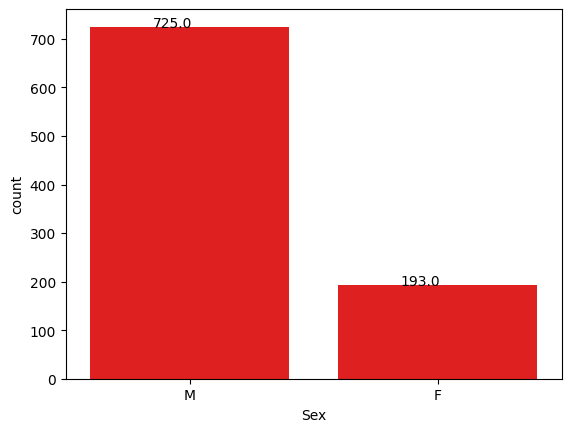

In [12]:
ax = sns.countplot(x="Sex", data=df,color='red')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

Most of the observation is coming from men!

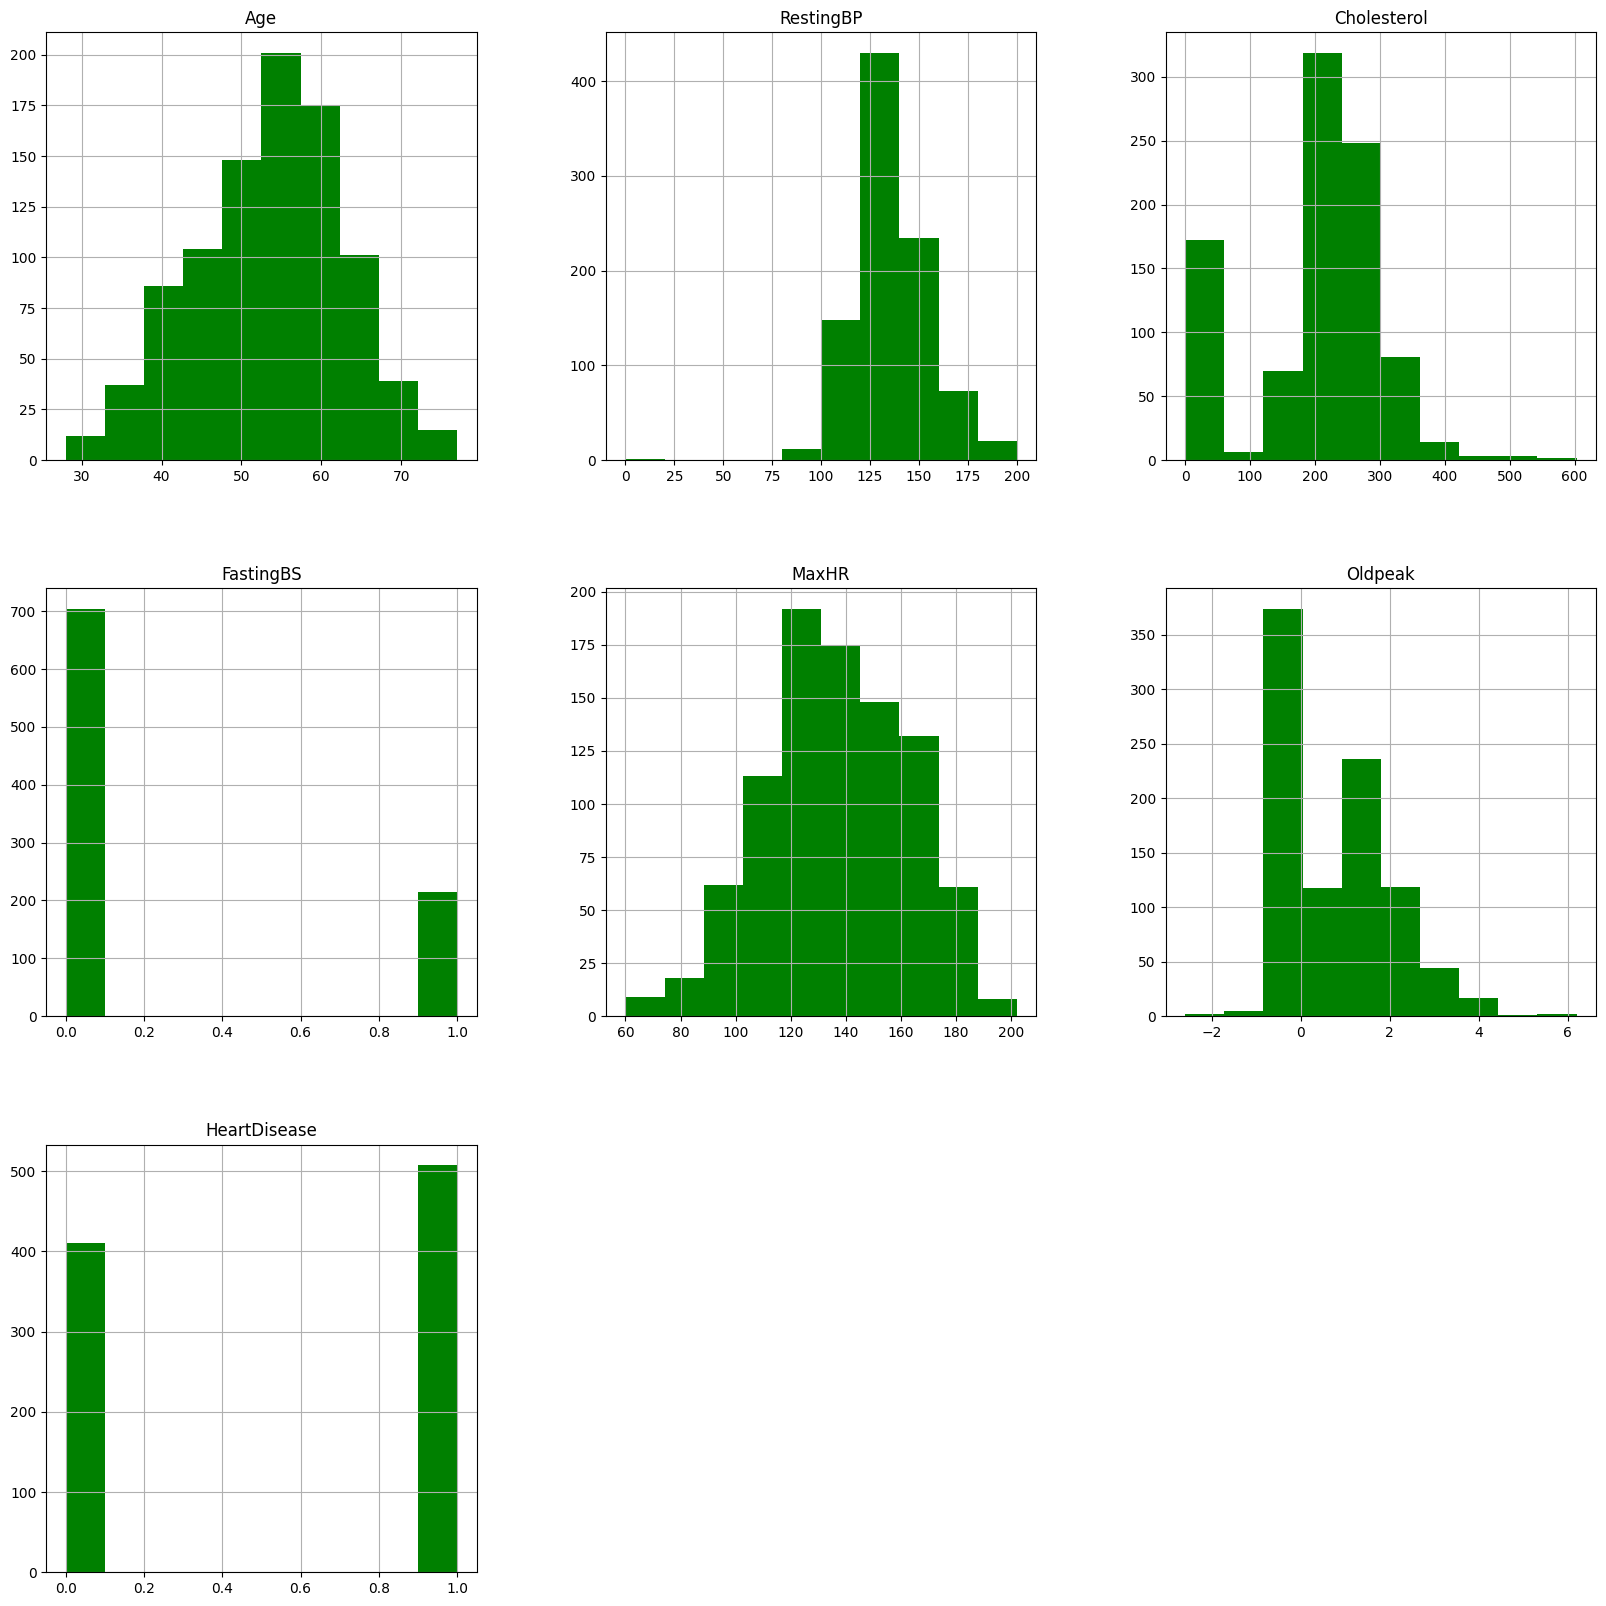

In [13]:
# plot histograms for each numerical variable
df.hist(figsize = (20, 20),color='green')
plt.show()

Some features skewed a bit! Let's investigate them!

In [14]:
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and

    # Define figure size.
    plt.figure(figsize=(20, 4))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()

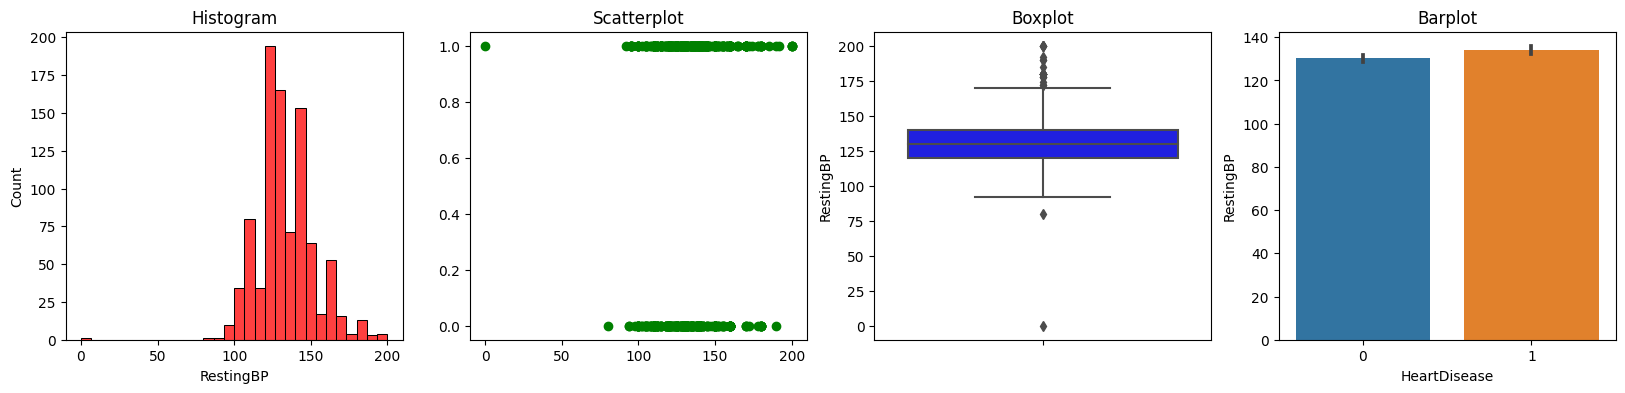

In [15]:
diagnostic_plots(df,'RestingBP','HeartDisease')

 * `RestingBP` is between 70-200 and has outliers, zero values!

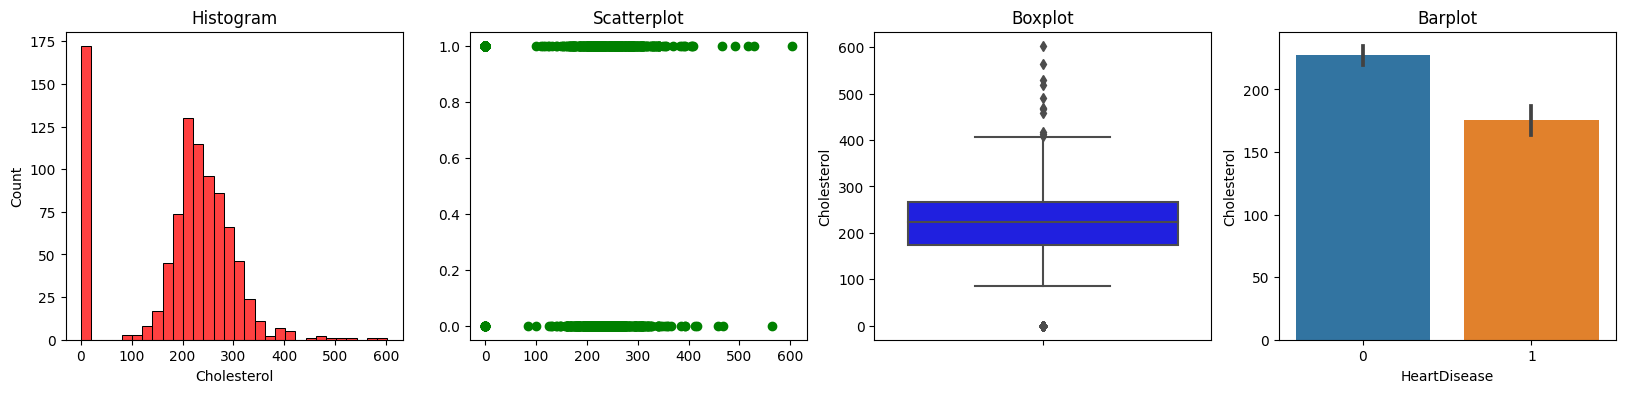

In [16]:
diagnostic_plots(df,'Cholesterol','HeartDisease')

 * `Cholesterol` is between 0-600 and has outliers!

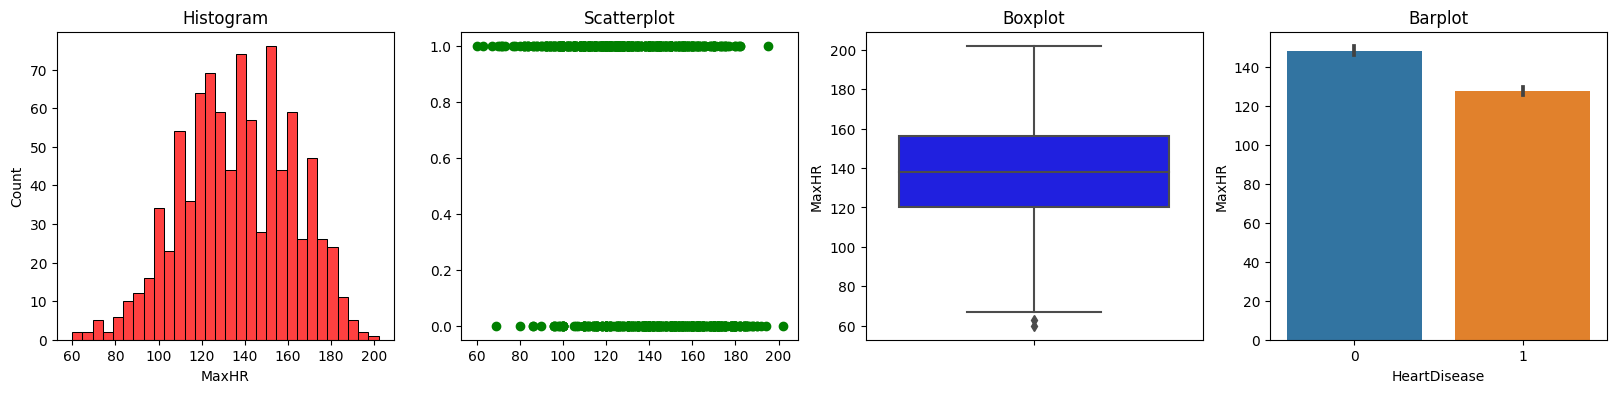

In [17]:
diagnostic_plots(df,'MaxHR','HeartDisease')

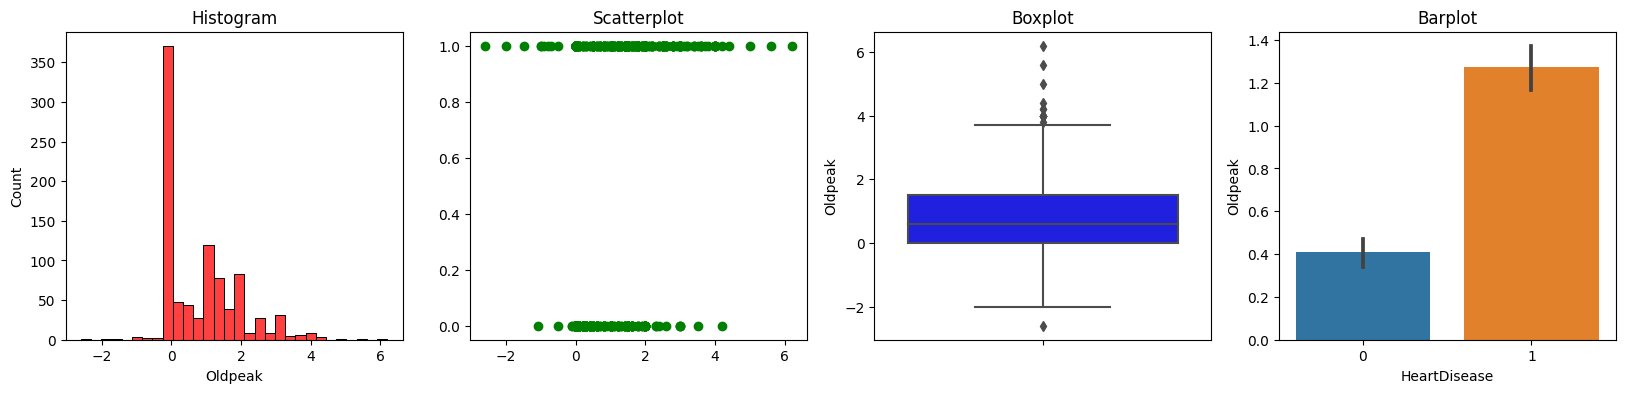

In [18]:
diagnostic_plots(df,'Oldpeak','HeartDisease')

We have outliers!

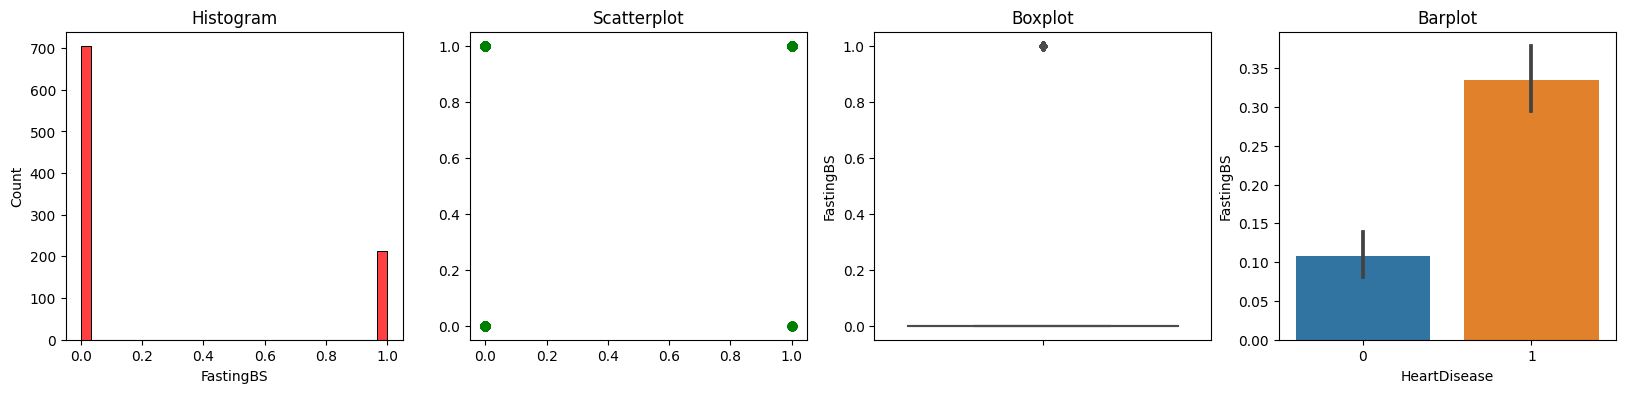

In [19]:
diagnostic_plots(df,'FastingBS','HeartDisease')

In [20]:
# We have only 0's and 1's in this feature.
df.FastingBS.value_counts()

0    704
1    214
Name: FastingBS, dtype: int64

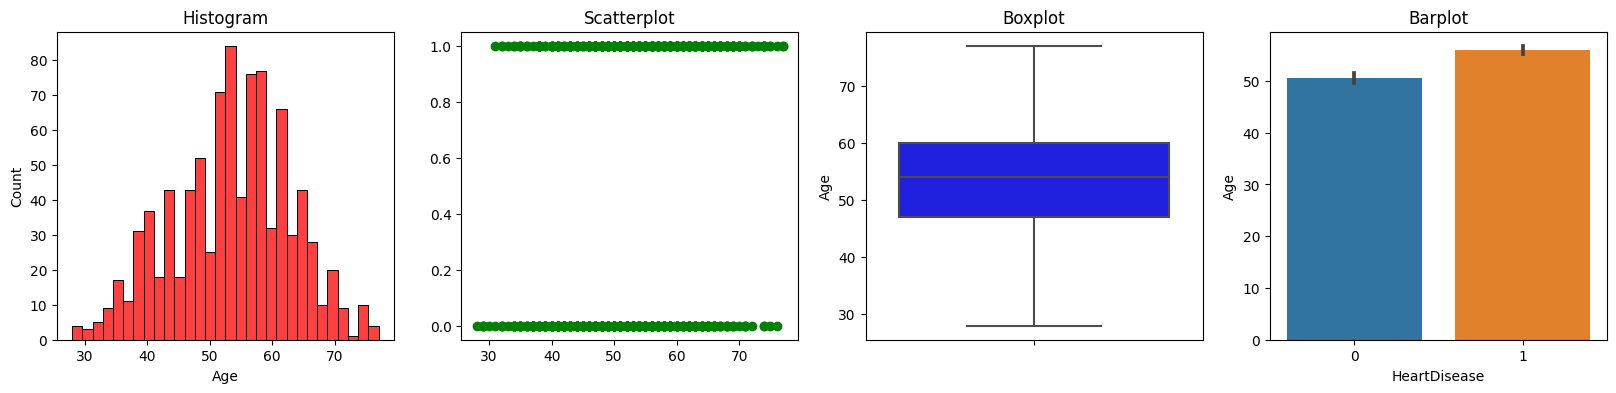

In [21]:
diagnostic_plots(df,'Age','HeartDisease')

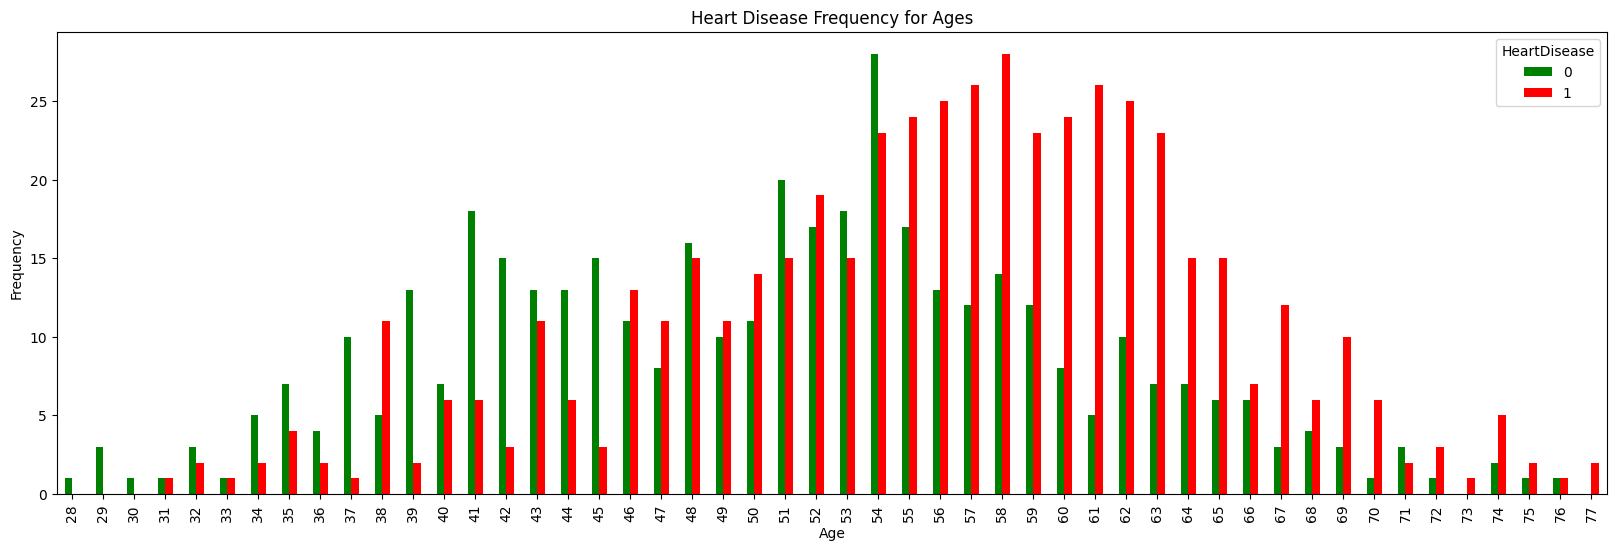

In [22]:
pd.crosstab(df.Age,df.HeartDisease).plot(kind="bar",figsize=(20,6),color= ['green','red'])
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

* Heart diseases rising the ages between 45-68.

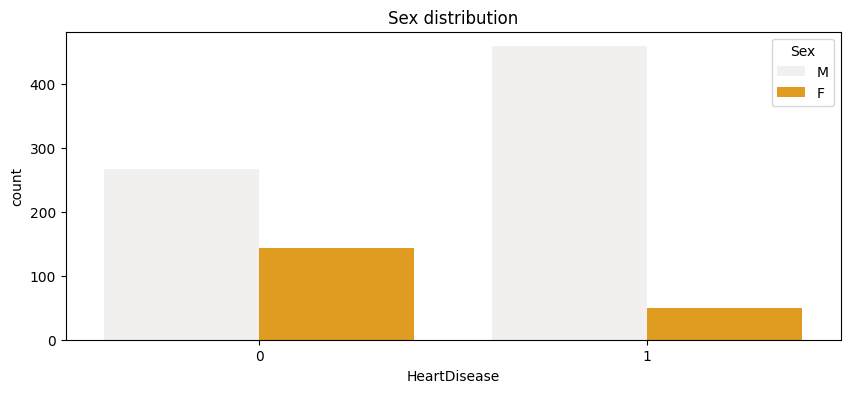

In [23]:
plt.figure(figsize=(10,4))
g = sns.countplot(data=df, x='HeartDisease', hue='Sex',color='orange')
plt.title('Sex distribution')
plt.show()

## Feature Engineering

###  `RestingBP`

The patient's blood pressure is represented by restingBP. Due to the fact that it is impossible to have values equal to 0, I will do median imputation to the outliers.

In [24]:
def detect_outliers(df,features):
    df_copy = df.drop(df[(df[features] == 0)].index)
    # 1st quartile
    q1 = df_copy[features].quantile(0.25)
    # 3rd quartile
    q3 = df_copy[features].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    outlier_list_col = df_copy[(df_copy[features] >= Upper_tail) | (df_copy[features] <= Lower_tail)]  # | means "or"
    return pd.DataFrame(outlier_list_col)

In [25]:
RestingBP_outlier = detect_outliers(df,'RestingBP')
RestingBP_outlier.value_counts(RestingBP_outlier['HeartDisease'])

HeartDisease
1    28
0    13
dtype: int64

In [26]:
Cholesterol_outlier = detect_outliers(df,'Cholesterol')
Cholesterol_outlier.value_counts(Cholesterol_outlier['HeartDisease'])

HeartDisease
1    13
0    10
dtype: int64

In [27]:
imputer = SimpleImputer(strategy='median')

# We fit the imputer to the train set.
# The imputer will learn the median of all variables.
cols_to_use = ['Cholesterol','RestingBP']
imputer.fit(df[cols_to_use])

SimpleImputer(strategy='median')

In [28]:
df[cols_to_use] = imputer.transform(df[cols_to_use])

In [29]:
df.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

##  Missing Values

In [30]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

We don't have any missing values! That is great!

## Age

Let's divide the ages into age groups!

In [31]:
df['AgeGroup']= np.nan
df.loc[(df['Age']>=28) & (df['Age']<35),'AgeGroup']='Young Adult' 
df.loc[(df['Age']>=35) & (df['Age']<=64),'AgeGroup']='Adult'
df.loc[df['Age']>64,'AgeGroup']='Seniors'

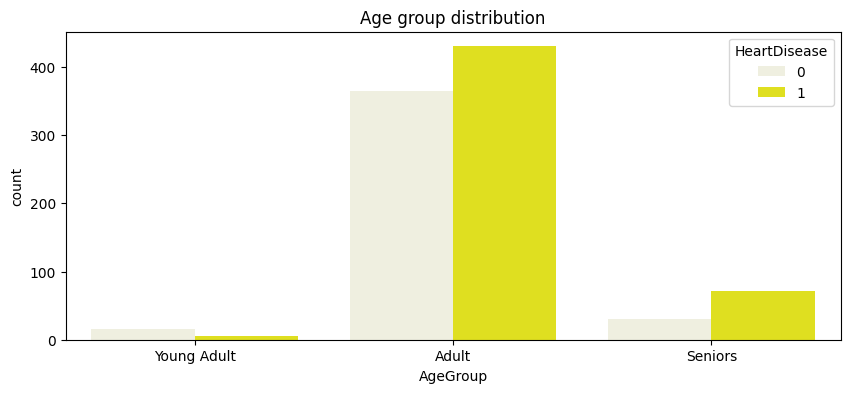

In [32]:
plt.figure(figsize=(10,4))
g=sns.countplot(data=df, x='AgeGroup', hue='HeartDisease', order=['Young Adult','Adult','Seniors'],color='yellow')
plt.title('Age group distribution')
plt.show()

In [33]:
df.drop(['Age'], axis=1, inplace=True)

## Encoding

In [34]:
catcols = ['Sex', 'ChestPainType','FastingBS','RestingECG',
            'ExerciseAngina',  'ST_Slope','AgeGroup']

In [35]:
def Label_Encoding(df,feature):
    label_encoder = LabelEncoder()
    df[feature]= label_encoder.fit_transform(df[feature])

In [36]:
for i in catcols:
    Label_Encoding(df,i)

In [37]:
df.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup
0,1,1,140.0,289.0,0,1,172,0,0.0,2,0,0
1,0,2,160.0,180.0,0,1,156,0,1.0,1,1,0
2,1,1,130.0,283.0,0,2,98,0,0.0,2,0,0
3,0,0,138.0,214.0,0,1,108,1,1.5,1,1,0
4,1,2,150.0,195.0,0,1,122,0,0.0,2,0,0


## Scaling

In [38]:
numcols  = ['RestingBP','Cholesterol','MaxHR']

In [39]:
scaler = StandardScaler()

# Scale data
df[numcols] = scaler.fit_transform(df[numcols])

In [40]:
df.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup
0,1,1,0.410909,0.825070,0,1,1.382928,0,0.0,2,0,0
1,0,2,1.491752,-0.171961,0,1,0.754157,0,1.0,1,1,0
2,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.0,2,0,0
3,0,0,0.302825,0.139040,0,1,-1.132156,1,1.5,1,1,0
4,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.0,2,0,0


## Train test split

In [41]:
# Set up X and y variables
y, X = df['HeartDisease'], df.drop(columns='HeartDisease')

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Prediction


### 1. K-Nearest Neighbor Classifier

In [136]:
# Building a model using KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
y_pred = knn.predict(X_test)

In [49]:
knnAcc = accuracy_score(y_test,y_pred)
knnAcc

0.8659420289855072

<Axes: >

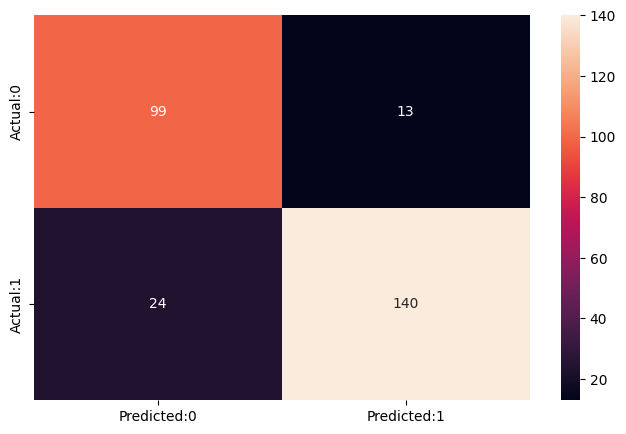

In [50]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

### 2. Support Vector Machine

In [55]:
svm = SVC(random_state=1)
svm.fit(X_train,y_train)

SVC(random_state=1)

In [56]:
y_pred = svm.predict(X_test)

In [57]:
svmAcc = accuracy_score(y_test,y_pred)
svmAcc

0.8840579710144928

<Axes: >

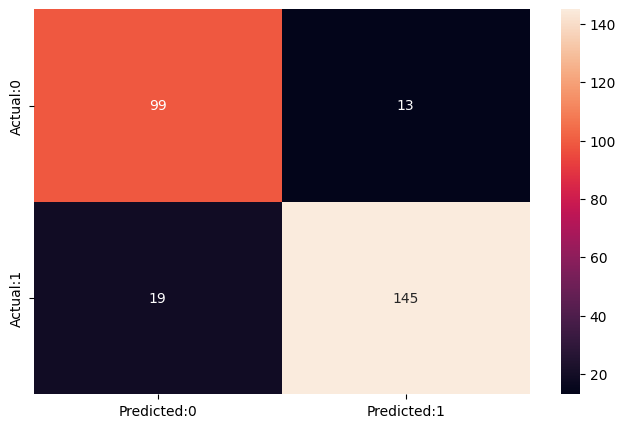

In [58]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## Comparison

In [138]:
data={'Estimators':['K-Nearest Neighbor','Support Vector Machine'],
      'Accuracy':[knnAcc,svmAcc]}

data =pd.DataFrame(data)

data.sort_values('Accuracy', ascending=False)

,Estimators,Accuracy
1,Support Vector Machine,0.884058
0,K-Nearest Neighbor,0.865942


Support vector machine is best among all of the estimators.

# Dataset 2 (Income classification)

In [145]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [146]:
df= pd.read_csv('income_evaluation.csv')

In [147]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Data Processing and Visualisations:

In [148]:
df=df.drop(' fnlwgt', axis=1)

In [149]:
df=df.drop(' education', axis=1)

In [150]:
df

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Identifying categorical variables

In [151]:
cat_cols = list(df.select_dtypes(include=['object']).columns)
print(f"Number of categorical columns: {len(cat_cols)}")
print(f"Categorical columns:\n{cat_cols}")

Number of categorical columns: 8
Categorical columns:
[' workclass', ' marital-status', ' occupation', ' relationship', ' race', ' sex', ' native-country', ' income']


## Identifying numerical variables:

In [152]:
num_cols = [x for x in df.select_dtypes(include=["number"]).columns
            if x not in cat_cols
            if x not in [" income"]]
print(f"Number of numerical columns: {len(num_cols)}")
print(f"Numerical columns:\n{num_cols}")

Number of numerical columns: 5
Numerical columns:
['age', ' education-num', ' capital-gain', ' capital-loss', ' hours-per-week']


## Checking for missing values:

In [153]:
# List of columns that have null values
features_with_na = [col for col in df.columns if df[col].isna().sum() > 0]

# Precentage of missing data
missing_values_df = pd.DataFrame(df[features_with_na].isnull().mean().sort_values(ascending=False), columns=["percentage"])


In [154]:
# How many features are missing more than some threshold
print(
    f"25% : {len(missing_values_df[missing_values_df['percentage'] > 0.25])}\n\
50% :  {len(missing_values_df[missing_values_df['percentage'] > 0.50])}\n\
75% :  {len(missing_values_df[missing_values_df['percentage'] > 0.75])}\n\
80% :  {len(missing_values_df[missing_values_df['percentage'] > 0.80])}\n\
90% :  {len(missing_values_df[missing_values_df['percentage'] > 0.90])}\n"
)

25% : 0
50% :  0
75% :  0
80% :  0
90% :  0



## Filling in NaN values:

In [155]:
from sklearn.impute import SimpleImputer

# create an imputer object
imputer = SimpleImputer(strategy='mean')

# impute NaN values in numeric columns
numeric_columns = num_cols
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# impute NaN values in categorical columns
categorical_columns = cat_cols
df[categorical_columns] = df[categorical_columns].fillna('Unknown')


## Creating Visualisations with the given data:

### 1. Target Variable Income:

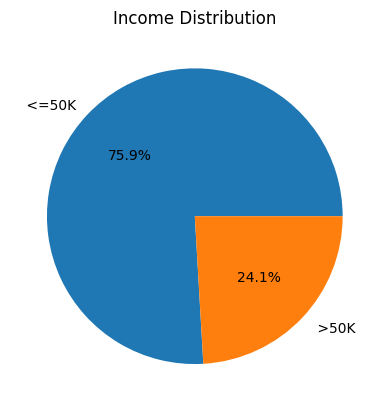

In [156]:
import matplotlib.pyplot as plt
import pandas as pd

income_counts = df[' income'].value_counts()
plt.pie(income_counts, labels=income_counts.index, autopct='%1.1f%%')
plt.title('Income Distribution')
plt.show()


### 2. Individual features and their relationship with the target variable:

#### a) Occupation and Income:

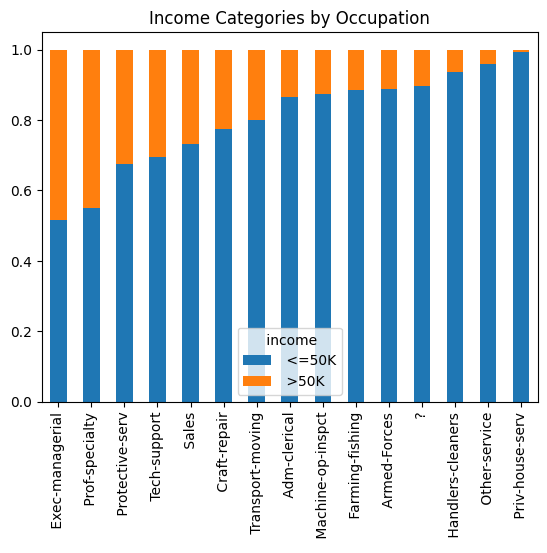

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a crosstab of occupation and income categories
df_ct = pd.crosstab(df[' occupation'], df[' income'])

# Calculate the percentage of each income category for each occupation
df_pct = df_ct.apply(lambda r: r/r.sum(), axis=1)

# Sort the data by the percentage of greater than 50K income category in descending order
df_pct = df_pct.sort_values(by=' >50K', ascending=False)

# Create a stacked bar chart of income categories by occupation
df_pct.plot(kind='bar', stacked=True)

plt.xlabel('')
plt.ylabel('')
plt.title('Income Categories by Occupation')
plt.xticks(rotation=90)
plt.show()


#### b) Income distribution by Race and Sex:

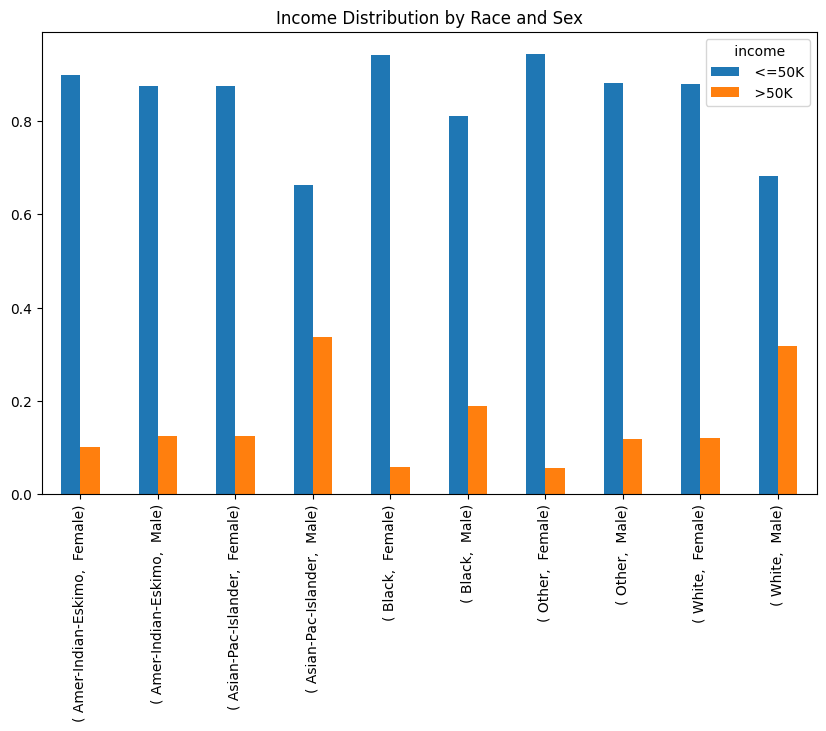

In [158]:
ct = pd.crosstab(index=[df[' race'], df[' sex']], columns=df[' income'], normalize='index')
ct.plot(kind='bar', figsize=(10, 6))# create a grouped bar chart
plt.title('Income Distribution by Race and Sex')
plt.xlabel('')
plt.ylabel('')
plt.show()


#### c) Distribution of marital status:

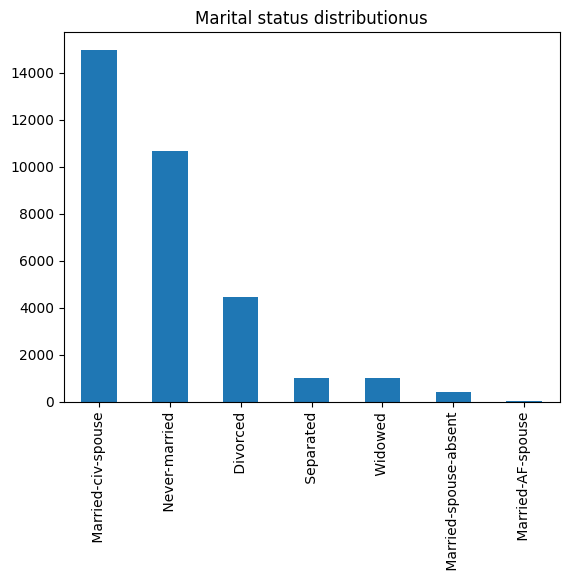

In [159]:
import matplotlib.pyplot as plt
import pandas as pd

df[' marital-status'].value_counts().plot(kind='bar')
plt.xlabel('')
plt.ylabel('')
plt.title('Marital status distributionus')
plt.show()


#### d) Relationship between marital status and income:

<Axes: xlabel=' income', ylabel=' marital-status'>

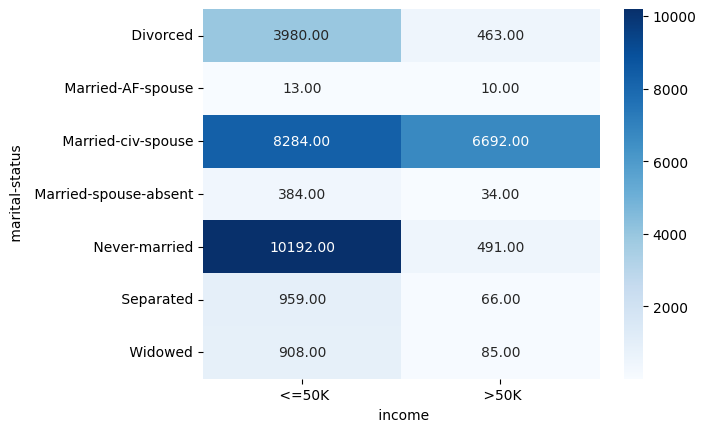

In [160]:
table = pd.crosstab(df[' marital-status'], df[' income'])
sns.heatmap(table, annot=True, fmt='.2f', cmap='Blues')


#### e) Distribution of income by age and hours worked per week:

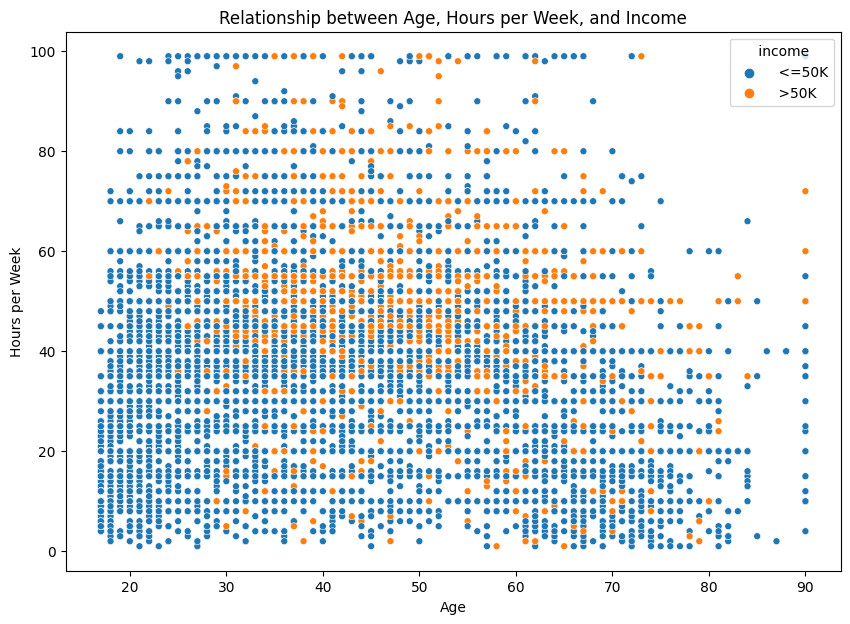

In [161]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x= "age", y=" hours-per-week", hue=" income", s=25)
plt.title("Relationship between Age, Hours per Week, and Income")
plt.xlabel("Age")
plt.ylabel("Hours per Week")
plt.show()


#### f) Distribution of income by age and sex

<Axes: xlabel=' sex', ylabel='age'>

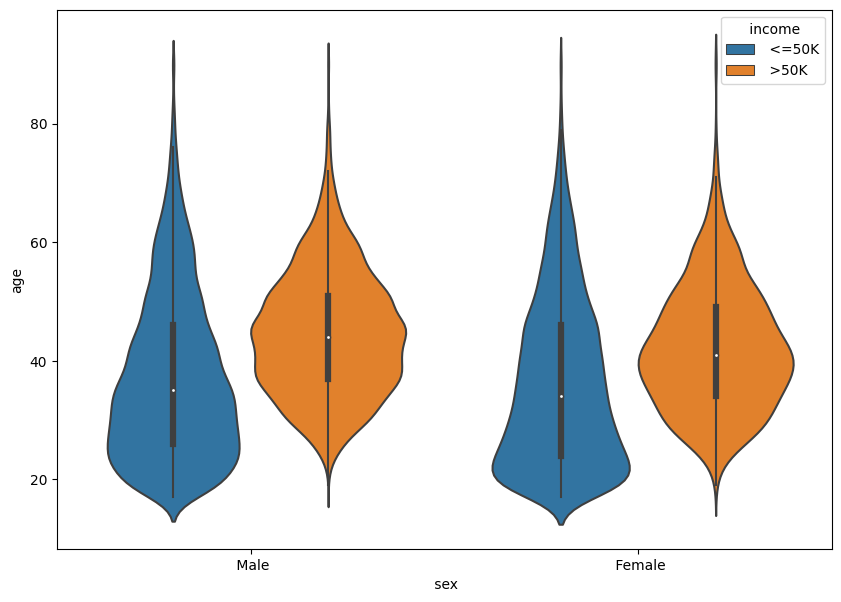

In [162]:
plt.figure(figsize=(10,7))
# create a violin plot with sex on the x-axis, age on the y-axis, and income as the hue
sns.violinplot(data=df, x=' sex', y='age', hue=' income')



## Label Encoding:


In [163]:
from sklearn.preprocessing import LabelEncoder

# create a label encoder object
le = LabelEncoder()

# # encode the target variable
# y = le.fit_transform(df)

# encode categorical variables in the DataFrame
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])


In [164]:
df

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39,0
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39,0
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39,0
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39,0
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39,0
32557,40.0,4,9.0,2,7,0,4,1,0.0,0.0,40.0,39,1
32558,58.0,4,9.0,6,1,4,4,0,0.0,0.0,40.0,39,0
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39,0


In [165]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numeric_cols)

['age', ' workclass', ' education-num', ' marital-status', ' occupation', ' relationship', ' race', ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country', ' income']


## Scaling the data with Min-Max Scaler:


In [166]:
# Min Max Scaler: transformation of data

names = df.columns
indexes = df.index
sc = MinMaxScaler((0, 1)) #between 0 and 1 range
df = sc.fit_transform(df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,0.875,0.800000,0.666667,0.071429,0.2,1.0,1.0,0.02174,0.0,0.397959,0.951220,0.0
1,0.452055,0.750,0.800000,0.333333,0.285714,0.0,1.0,1.0,0.00000,0.0,0.122449,0.951220,0.0
2,0.287671,0.500,0.533333,0.000000,0.428571,0.2,1.0,1.0,0.00000,0.0,0.397959,0.951220,0.0
3,0.493151,0.500,0.400000,0.333333,0.428571,0.0,0.5,1.0,0.00000,0.0,0.397959,0.951220,0.0
4,0.150685,0.500,0.800000,0.333333,0.714286,1.0,0.5,0.0,0.00000,0.0,0.397959,0.121951,0.0


In [167]:
y = data_scaled[' income']

# Extract the input features
X_data = data_scaled.drop([' income'], axis=1)

# Feature Engineering:

## Selecting best features using Pearsons Correlation and KBest Features.

#### 1. Pearsons Correlation:

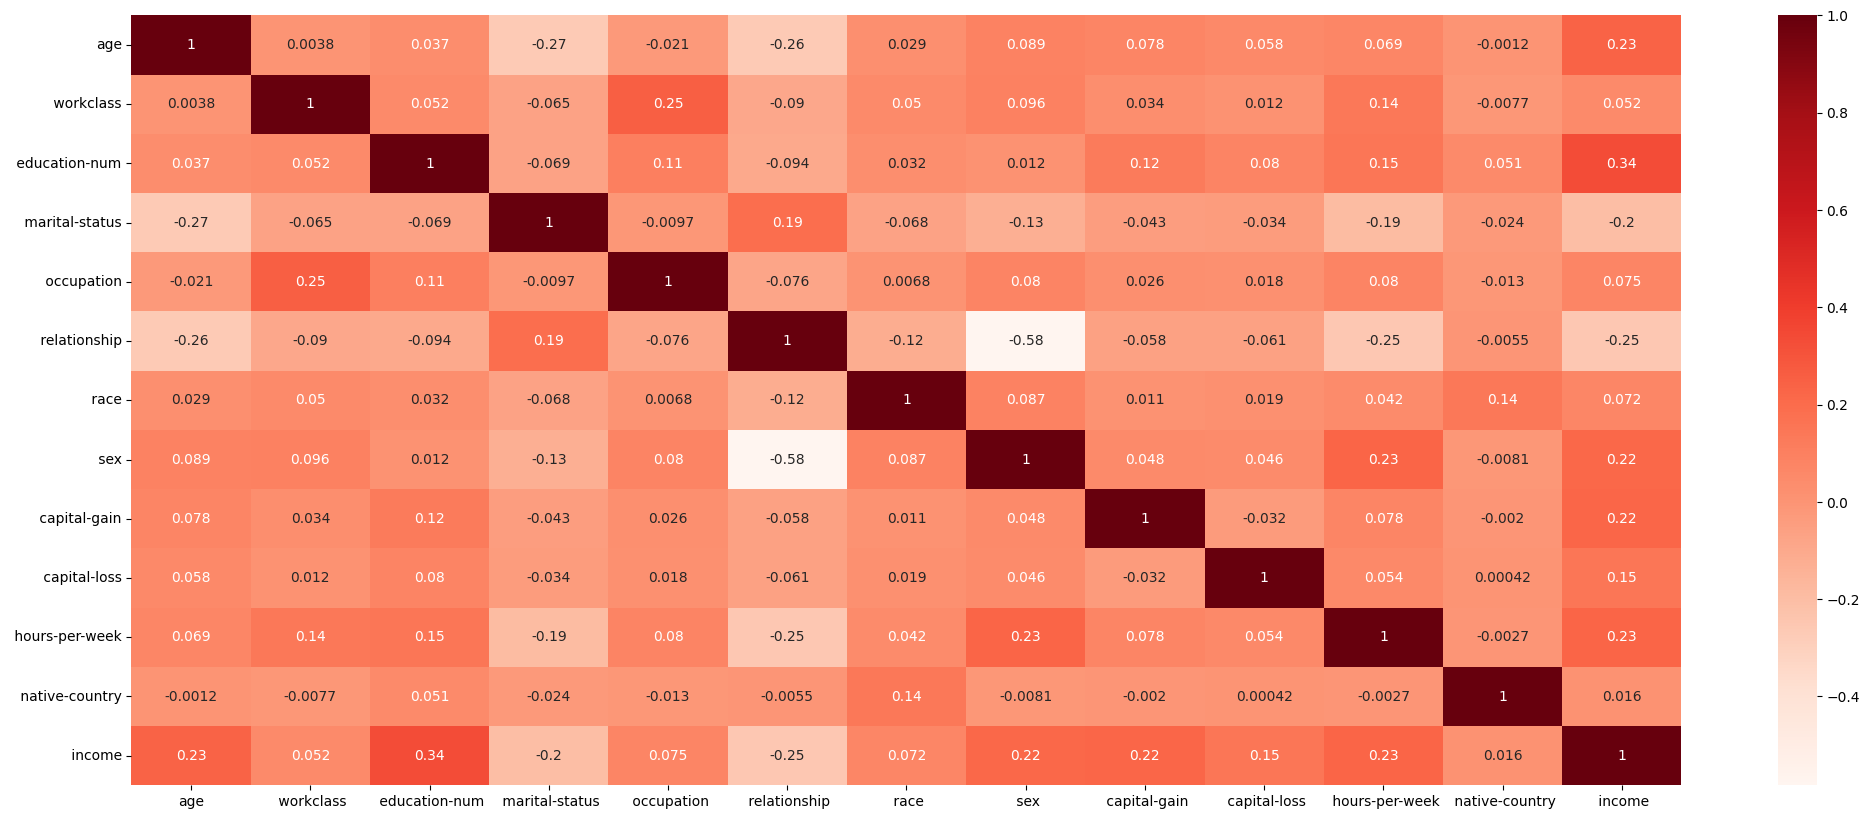

In [168]:
#Using Pearson Correlation
plt.figure(figsize=(25,10))
cor = data_scaled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [169]:
#Correlation with target variable price
cor_target = abs(cor[" income"])

relevant_features = cor_target
relevant_features 

age                0.234037
 workclass         0.051604
 education-num     0.335154
 marital-status    0.199307
 occupation        0.075468
 relationship      0.250918
 race              0.071846
 sex               0.215980
 capital-gain      0.223329
 capital-loss      0.150526
 hours-per-week    0.229689
 native-country    0.015840
 income            1.000000
Name:  income, dtype: float64

#### 2. KBest Features:

In [170]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=7)
X_important = selector.fit_transform(X_data, y)
mask = selector.get_support()
important_feature_names = X_data.columns[mask]

print(important_feature_names)

Index(['age', ' education-num', ' marital-status', ' relationship', ' sex',
       ' capital-gain', ' hours-per-week'],
      dtype='object')


In [171]:
X = data_scaled.drop([' workclass', ' occupation', ' race', ' native-country',
       ' income'],1)  #Feature Matrix
                     
y = data_scaled[" income"]          #Target Variable


# Splitting data into Training and testing sets:

In [172]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=46)

# Building models and evaluating their performances:

## 1. Random Forest Classifier

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score


rf = RandomForestClassifier()

rf.fit(X_train, y_train)

# Predict the labels on train and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and print the train and test accuracies
train_acc_rf = accuracy_score(y_train, y_train_pred)
test_acc_rf = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc_rf}")
print(f"Test accuracy: {test_acc_rf}")


Train accuracy: 0.9250230343980343
Test accuracy: 0.8420082911100876


<Axes: >

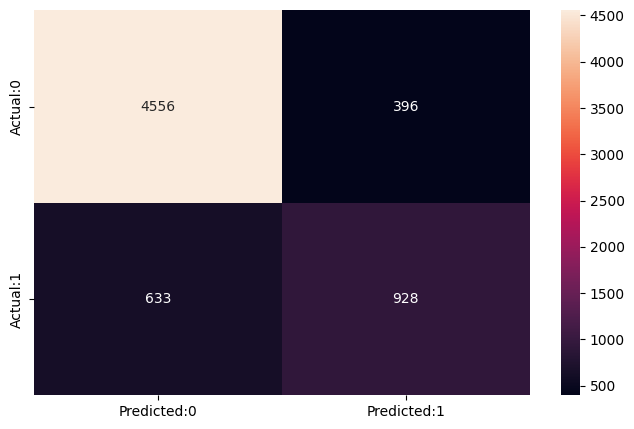

In [175]:
cm = confusion_matrix(y_test,y_test_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## 2. XGBoost

In [134]:
import xgboost as xgb

xgb = xgb.XGBClassifier()

xgb.fit(X_train, y_train)

# Predict the labels on train and test sets
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Calculate and print the train and test accuracies
train_acc_xg = accuracy_score(y_train, y_train_pred)
test_acc_xg = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc_xg}")
print(f"Test accuracy: {test_acc_xg}")


Train accuracy: 0.8798756142506142
Test accuracy: 0.8636573007830493


<Axes: >

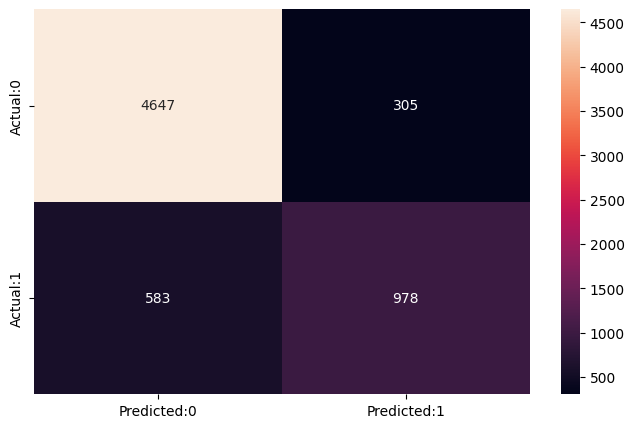

In [140]:
cm = confusion_matrix(y_test,y_test_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## Comparison

In [135]:
data={'Estimators':['Random forest classifer', 'XG Boost'],
      'Accuracy':[test_acc_rf,test_acc_xg]}

data =pd.DataFrame(data)

data.sort_values('Accuracy', ascending=False)

,Estimators,Accuracy
1,XG Boost,0.863657
0,Random forest classifer,0.843083
